In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [7]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/copy assignment6/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/copy assignment6/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kominfoPROA/copy assignment6/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [8]:
y_train

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
15995    sadness
15996    sadness
15997        joy
15998      anger
15999    sadness
Name: Emotion, Length: 16000, dtype: object

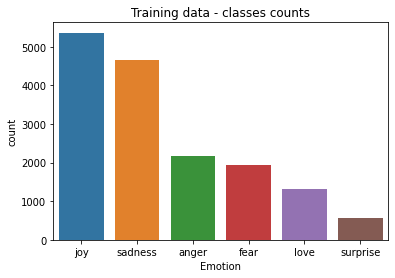

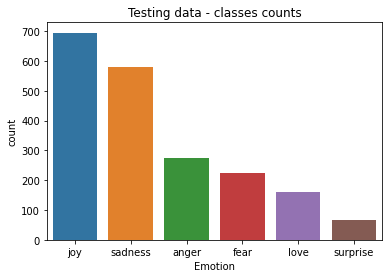

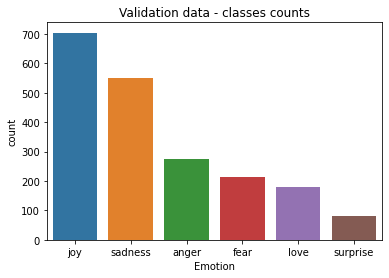

In [9]:
# Visualize classes counts
#colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

sns.countplot(data=df_train, x='Emotion', order = df_train['Emotion'].value_counts().index)
plt.title("Training data - classes counts")
plt.show()

sns.countplot(data=df_test, x='Emotion', order = df_test['Emotion'].value_counts().index)
plt.title("Testing data - classes counts")
plt.show()

sns.countplot(data=df_val, x='Emotion', order = df_val['Emotion'].value_counts().index)
plt.title("Validation data - classes counts")
plt.show()

In [10]:
# Encode labels

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [12]:
#after we use label encoder, it will encode based on the first alphabet
# like anger=0, fear=1, joy=2, love=3, sadness=4, surprise=5
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
# Embedding
max_features = vocabSize
maxlen = X_train.shape[1]
embedding_size = 200

# Convolution
kernel_size = 5
filters = 256
pool_size = 4

# LSTM
lstm_output_size = 256

In [ ]:
model = Sequential()
model.add(Embedding(vocabSize, embedding_size, input_length=X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(6))
model.add(Activation('softmax'))

#adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 dropout (Dropout)           (None, 256, 200)          0         
                                                                 
 conv1d (Conv1D)             (None, 252, 256)          256256    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 63, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [ ]:
#Callback
#reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy', 
    factor=0.2,         
    patience=5, 
    mode='auto',
    min_lr=2e-7)

#early stop
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=10,
    min_delta=0,
    verbose=0,
    mode='auto',
    restore_best_weights = True,
    baseline=None)

In [ ]:
# Fit model

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=256,
                    epochs=75,
                    callbacks=[reduce_lr, early_stop],
                    verbose=1
                   )

Epoch 1/75
63/63 [==============================] - 18s 66ms/step - loss: 1.5341 - accuracy: 0.3856 - val_loss: 1.2384 - val_accuracy: 0.5615 - lr: 0.0010
Epoch 2/75
63/63 [==============================] - 3s 55ms/step - loss: 0.7205 - accuracy: 0.7293 - val_loss: 0.4822 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 3/75
63/63 [==============================] - 3s 55ms/step - loss: 0.2408 - accuracy: 0.9168 - val_loss: 0.2544 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 4/75
63/63 [==============================] - 3s 55ms/step - loss: 0.0979 - accuracy: 0.9656 - val_loss: 0.2611 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 5/75
63/63 [==============================] - 4s 56ms/step - loss: 0.0552 - accuracy: 0.9797 - val_loss: 0.2806 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 6/75
63/63 [==============================] - 4s 56ms/step - loss: 0.0399 - accuracy: 0.9855 - val_loss: 0.3287 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 7/75
63/63 [==============================] - 4s 57ms/step - loss: 0.

In [ ]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 1s 7ms/step - loss: 0.4387 - accuracy: 0.9140


[0.43873104453086853, 0.9139999747276306]

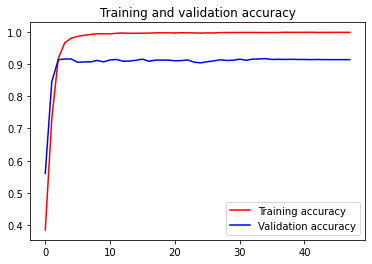

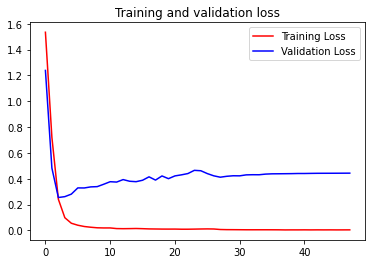

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = ['i wasnt very interested in it but it evoked the feeling of an earth grittily doomed by aliens quite well',
             'i managed however to relax and enjoy the scenery feeling romantic and thoroughly enjoying our th anniversary cruise',
             'i hope i get the job cause im in desperate need of money and i feel greedy',
             'i get scared i feel ignored i feel happy i get silly i choke on my own words i make wishes i have dreams and i still want to believe anything could happen in this world for an ordinary girl like you like me for an ordinary girl like you like me how are you',
             'i dont want you',
             'Lets having fun together'
            #sample teks
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

i wasnt very interested in it but it evoked the feeling of an earth grittily doomed by aliens quite well
sadness : 1.0

i managed however to relax and enjoy the scenery feeling romantic and thoroughly enjoying our th anniversary cruise
love : 0.9992684721946716

i hope i get the job cause im in desperate need of money and i feel greedy
anger : 0.9999995231628418

i get scared i feel ignored i feel happy i get silly i choke on my own words i make wishes i have dreams and i still want to believe anything could happen in this world for an ordinary girl like you like me for an ordinary girl like you like me how are you
sadness : 0.9999576807022095

i dont want you
anger : 0.4173435866832733

Lets having fun together
joy : 0.38612255454063416



In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition1.h5')